# Music Genre Classification

Task is to build 6 different classifiers for the music genre dataset GTZAN using different network architectures.

Dataset - https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

## Data preparation for networks 1-4
1. Resizing of the images to 180x180 (using torchvision.transforms.Resize).
2. Random split of the dataset into a training (70%), validation (20%), and test (10%) datasets.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtzan-dataset-music-genre-classification


In [2]:
import os

print(os.listdir(path+"/Data/images_original"))

['disco', 'metal', 'reggae', 'blues', 'rock', 'classical', 'jazz', 'hiphop', 'country', 'pop']


In [3]:
# data for networks 1-4

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

img_dir = path + "/Data/images_original"   # path to images

transform = transforms.Compose([
    transforms.Resize((180, 180)),  # resizing
    transforms.ToTensor()           # transormation to tensor
])

# dataset creation using previously defined tranformations
dataset = datasets.ImageFolder(root=img_dir, transform=transform)

# split on train, test, and validation subsets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size   = int(0.2 * total_size)
test_size  = total_size - train_size - val_size   # overall sum must equal total_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(666)  # for the same result regardless of experiments
)

print(f"Dataset: {len(dataset)}, Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Dataset: 999, Train: 699, Val: 199, Test: 101


In [4]:
from collections import Counter

# Функція для отримання розподілу класів у датасеті
def get_class_distribution(dataset):
    class_labels = [item[1] for item in dataset]
    class_counts = Counter(class_labels)
    return class_counts

class_distribution = get_class_distribution(dataset)
train_class_distribution = get_class_distribution(train_dataset)
val_class_distribution = get_class_distribution(val_dataset)
test_class_distribution = get_class_distribution(test_dataset)

print("Розподіл класів у датасеті:", class_distribution)
print("Розподіл класів у тренувальному датасеті:", train_class_distribution)
print("Розподіл класів у валідаційному датасеті:", val_class_distribution)
print("Розподіл класів у тестовому датасеті:", test_class_distribution)

Розподіл класів у датасеті: Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 6: 100, 7: 100, 8: 100, 9: 100, 5: 99})
Розподіл класів у тренувальному датасеті: Counter({4: 79, 0: 74, 5: 73, 3: 72, 6: 70, 7: 70, 2: 69, 8: 67, 1: 63, 9: 62})
Розподіл класів у валідаційному датасеті: Counter({1: 26, 6: 23, 9: 22, 8: 22, 3: 20, 5: 20, 7: 19, 0: 19, 2: 17, 4: 11})
Розподіл класів у тестовому датасеті: Counter({9: 16, 2: 14, 7: 11, 8: 11, 1: 11, 4: 10, 3: 8, 6: 7, 0: 7, 5: 6})


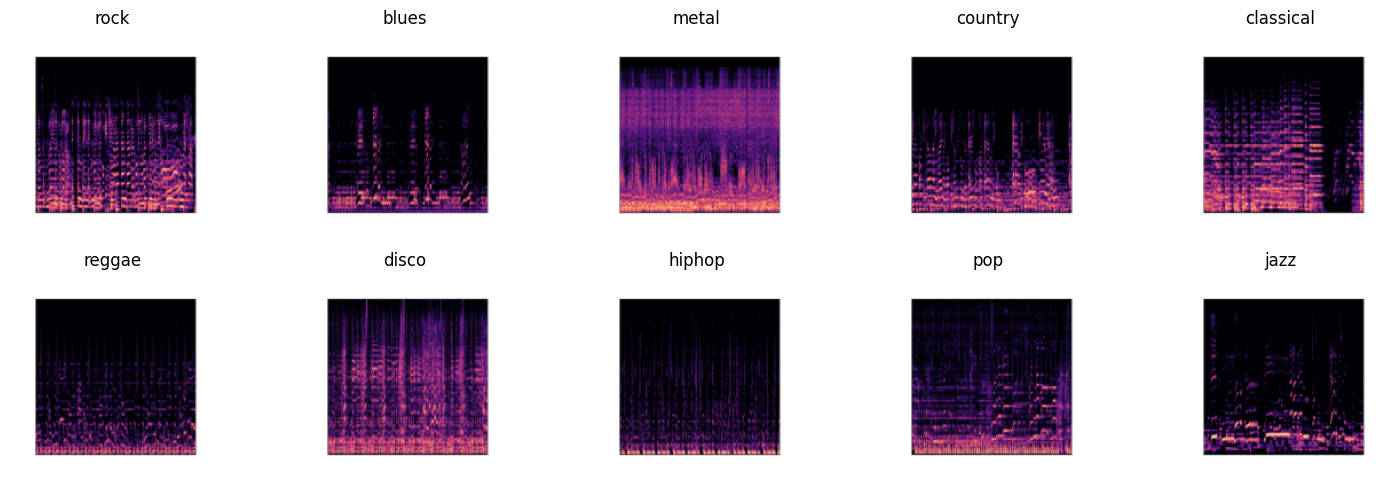

In [ ]:
import matplotlib.pyplot as plt

class_names = dataset.classes
shown = set()

plt.figure(figsize=(15, 5))
i = 0

for img, label in train_dataset:
    if label not in shown:
        img = img.numpy().transpose((1, 2, 0)) # tensor has order -> [Channels, Height, Width], matplotlib -> [Height, Width, Channels]
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis('off')
        shown.add(label)
        i += 1
    if len(shown) == len(class_names):
        break

plt.tight_layout()
plt.show()

In [5]:
# tranform data to batches

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [6]:
batch = next(iter(train_loader))
images, labels = batch

# check sizes
print("Batch shape:", images.shape)   # (batch_size, channels, height, width)
print("Labels shape:", labels.shape)
print("Number of batches in train_loader:", len(train_loader))
print("Number of images in train_loader:", len(train_loader.dataset))

print("\nNumber of classes:", len(dataset.classes))
print("Classes:", dataset.classes)

Batch shape: torch.Size([32, 3, 180, 180])
Labels shape: torch.Size([32])
Number of batches in train_loader: 22
Number of images in train_loader: 699

Number of classes: 10
Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [7]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### Train function

In [10]:
def train_model(num_epochs, model, optimizer):
    """
    Function for training and validating a model.
    It trains the model for a given number of epochs, calculates the loss and accuracy
    for both training and validation sets, and prints results after each epoch.

    Args:
        num_epochs (int): number of epochs to train
        model (torch.nn.Module): model that needs to be trained
        optimizer (torch.optim.Optimizer): optimization algorithm (like Adam or RMSprop)
    """

    for epoch in range(num_epochs):

        # ===== TRAINING PHASE =====

        model.train()  # sets the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs.contiguous()  # ensure inputs are stored continuously in memory
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # set all gradients to zero before backpropagation

            outputs = model(inputs)                        # forward pass: get predictions
            loss = model_loss(outputs, labels)             # calculate how wrong the predictions are

            loss.backward()                                # backward pass: compute gradients
            optimizer.step()                               # update model parameters

            running_loss += loss.item()                    # add loss value for statistics
            _, predicted = torch.max(outputs, 1)           # get predicted class
            total += labels.size(0)                        # total number of samples seen
            correct += (predicted == labels).sum().item()  # count how many were correct

        # ===== VALIDATION PHASE =====

        model.eval()  # sets the model to evaluation mode
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # no gradients needed for validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = model_loss(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Print results after each epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {correct/total}, Val_loss: {val_loss/len(val_loader)}, Val_acc: {val_correct/val_total}')

### Test function

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def test_model(model):
    """
    Function for testing a trained model on the test set.
    It calculates the test loss and accuracy, collects all predictions
    and true labels, and shows a confusion matrix.

    Args:
        model (torch.nn.Module): trained model to test
    """

    model.eval()  # set model to evaluation mode
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    all_preds = []   # will store all predicted labels
    all_labels = []  # will store all true labels

    with torch.no_grad():  # no gradients needed for testing
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)               # forward pass
            loss = model_loss(outputs, labels)    # compute loss

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)   # get predicted class
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())  # move predictions to CPU and save
            all_labels.extend(labels.cpu().numpy())    # move labels to CPU and save

    print(f"Test_loss: {test_loss / len(test_loader)}, Test_accuracy: {test_correct / test_total}")

    # ===== PLOT CONFUSION MATRIX =====

    cm = confusion_matrix(all_labels, all_preds)  # calculate confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Purples, ax=ax, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

### 1. A fully connected network with two hidden layers.

In [ ]:
import torch.nn as nn

class Net1(nn.Module):
  """
    A fully connected neural network.
    The input images are first flattened and passed through two hidden layers
    with ReLU activation, and then through the final output layer.

    Structure:
    - Flatten the input
    - Linear layer (3*180*180 -> 128)
    - ReLU activation
    - Linear layer (128 -> 64)
    - ReLU activation
    - Linear layer (64 -> 10 outputs for 10 classes)
    """
  def __init__(self):
      super(Net1, self).__init__()
      self.hidden_layer1=nn.Linear(3*180*180, 128)   # first hidden layer
      self.hidden_layer2=nn.Linear(128, 64)          # second hidden layer
      self.output_layer=nn.Linear(64, 10)            # output hidden layer for 10 classes
      self.relu=nn.ReLU()                            # nonlinear activation function, without it output is linear tranformartion of input
      self.flatten = nn.Flatten()                    # reshaping to one-dimensional tensor

  def forward(self, x):
      x = self.flatten(x)        # flatten the input image
      x = self.hidden_layer1(x)  # pass through first hidden layer
      x = self.relu(x)           # apply activation
      x = self.hidden_layer2(x)  # pass through second hidden layer
      x = self.relu(x)           # apply activation
      x = self.output_layer(x)   # pass through output layer
      return x

In [ ]:
import torch.optim as optim

# Two instances of the model Net1 are created: one for 50 epochs and one for 100 epochs
model_1_50 = Net1().to(device)
model_1_100 = Net1().to(device)

# The loss function is defined as CrossEntropyLoss
model_loss = nn.CrossEntropyLoss()

# The optimizers are defined as Adam with a learning rate of 0.0001
optimizer_50 = optim.Adam(model_1_50.parameters(), lr=0.0001)
optimizer_100 = optim.Adam(model_1_100.parameters(), lr=0.0001)

# Training is started for 50 epochs
print("\nTRAINING FOR 50 EPOCHS\n")
train_model(50, model_1_50, optimizer_50)

# Training is started for 100 epochs
print("\nTRAINING FOR 100 EPOCHS\n")
train_model(100, model_1_100, optimizer_100)

TRAINING FOR 50 EPOCHS
Epoch 1/50, Loss: 2.334029349413785, Accuracy: 0.12732474964234622, Val_loss: 2.1924030780792236, Val_acc: 0.21105527638190955
Epoch 2/50, Loss: 2.2023744474757803, Accuracy: 0.19027181688125894, Val_loss: 2.191702127456665, Val_acc: 0.20100502512562815
Epoch 3/50, Loss: 2.143256355415691, Accuracy: 0.20600858369098712, Val_loss: 2.0659234523773193, Val_acc: 0.22613065326633167
Epoch 4/50, Loss: 2.0817406394264917, Accuracy: 0.2246065808297568, Val_loss: 2.052112579345703, Val_acc: 0.18592964824120603
Epoch 5/50, Loss: 2.0439692627299917, Accuracy: 0.21745350500715308, Val_loss: 2.0754194259643555, Val_acc: 0.17587939698492464
Epoch 6/50, Loss: 2.013301182876934, Accuracy: 0.2703862660944206, Val_loss: 1.9737005233764648, Val_acc: 0.2864321608040201
Epoch 7/50, Loss: 2.0069228139790622, Accuracy: 0.2532188841201717, Val_loss: 2.020833730697632, Val_acc: 0.24120603015075376
Epoch 8/50, Loss: 1.9648559797893872, Accuracy: 0.2646638054363376, Val_loss: 1.99581205844

In [ ]:
model_1_50.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_1_50(inputs)
        loss = model_loss(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test_loss: {test_loss / len(test_loader)}, Test_accuracy: {test_correct / test_total}")

Test_loss: 1.5221301317214966, Test_accuracy: 0.42574257425742573


In [ ]:
model_1_100.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_1_100(inputs)
        loss = model_loss(outputs, labels)

        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test_loss: {test_loss / len(test_loader)}, Test_accuracy: {test_correct / test_total}")

Test_loss: 1.5284680128097534, Test_accuracy: 0.49504950495049505


### 2. The convolutional network shown in Figure with your own choice of parameters.

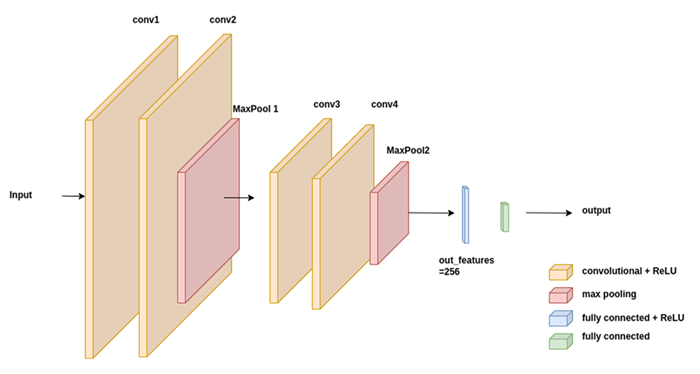


In [ ]:
import torch.nn as nn

class Net2(nn.Module):
    """
    A convolutional neural network (CNN) designed for image classification into 10 classes.

    Input shape: [batch_size, 3, 180, 180] where 3 is the number of color channels (RGB).

    The model consists of:
    - 4 convolutional layers with ReLU activation
    - 2 max-pooling layers for downsampling
    - Flattening into a 1D vector
    - 2 fully connected layers for final classification

    Output shape: [batch_size, 10] — raw class scores (logits).
    """

    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=42*42*256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

        # Activation function, pooling and flattening operations
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()

    def forward(self, x):
        # Input shape: [*, 3, 180, 180]
        x = self.conv1(x)
        x = self.relu(x)
        # After conv1: [*, 32, 178, 178]

        x = self.conv2(x)
        x = self.relu(x)
        # After conv2: [*, 64, 176, 176]

        x = self.pool(x)
        # After pool: [*, 64, 88, 88]

        x = self.conv3(x)
        x = self.relu(x)
        # After conv3: [*, 128, 86, 86]

        x = self.conv4(x)
        x = self.relu(x)
        # After conv4: [*, 256, 84, 84]

        x = self.pool(x)
        # After second pool: [*, 256, 42, 42]

        x = self.flatten(x)
        # After flatten: [*, 256*42*42]

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        # Final output: [*, 10]
        return x

In [ ]:
import torch.optim as optim

# Two instances of the model Net1 are created: one for 50 epochs and one for 100 epochs
model_2_50 = Net2().to(device)
model_2_100 = Net2().to(device)

# The loss function is defined as CrossEntropyLoss
model_loss = nn.CrossEntropyLoss()

# The optimizers are defined as Adam with a learning rate of 0.0001
optimizer_50 = optim.Adam(model_2_50.parameters(), lr=0.0001)
optimizer_100 = optim.Adam(model_2_100.parameters(), lr=0.0001)

# Training is started for 50 epochs
print("\nTRAINING FOR 50 EPOCHS\n")
train_model(50, model_2_50, optimizer_50)

# Training is started for 100 epochs
print("\nTRAINING FOR 100 EPOCHS\n")
train_model(100, model_2_100, optimizer_100)


TRAINING FOR 50 EPOCHS

Epoch 1/50, Loss: 2.3213890249078926, Accuracy: 0.10014306151645208, Val_loss: 2.2979612350463867, Val_acc: 0.20100502512562815
Epoch 2/50, Loss: 2.2646450888026846, Accuracy: 0.16738197424892703, Val_loss: 2.241302251815796, Val_acc: 0.1708542713567839
Epoch 3/50, Loss: 2.123148885640231, Accuracy: 0.22746781115879827, Val_loss: 2.014678478240967, Val_acc: 0.32160804020100503
Epoch 4/50, Loss: 2.0098837072199043, Accuracy: 0.28898426323319026, Val_loss: 1.905178427696228, Val_acc: 0.33668341708542715
Epoch 5/50, Loss: 1.8454110676592046, Accuracy: 0.3547925608011445, Val_loss: 1.7688066959381104, Val_acc: 0.3969849246231156
Epoch 6/50, Loss: 1.6375078667293896, Accuracy: 0.43204577968526464, Val_loss: 1.5708975791931152, Val_acc: 0.4371859296482412
Epoch 7/50, Loss: 1.4440820596434853, Accuracy: 0.4978540772532189, Val_loss: 1.7074472904205322, Val_acc: 0.36683417085427134
Epoch 8/50, Loss: 1.3196114951914006, Accuracy: 0.5593705293276109, Val_loss: 1.53499197

Result of Net2 for 50 epochs:
Test_loss: 2.0011168718338013, Test_accuracy: 0.6039603960396039


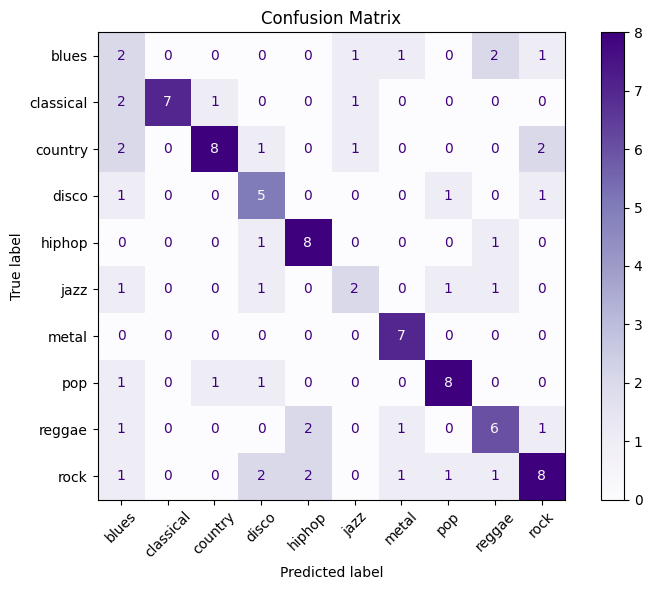


Result of Net2 for 100 epochs:
Test_loss: 2.241794615983963, Test_accuracy: 0.5346534653465347


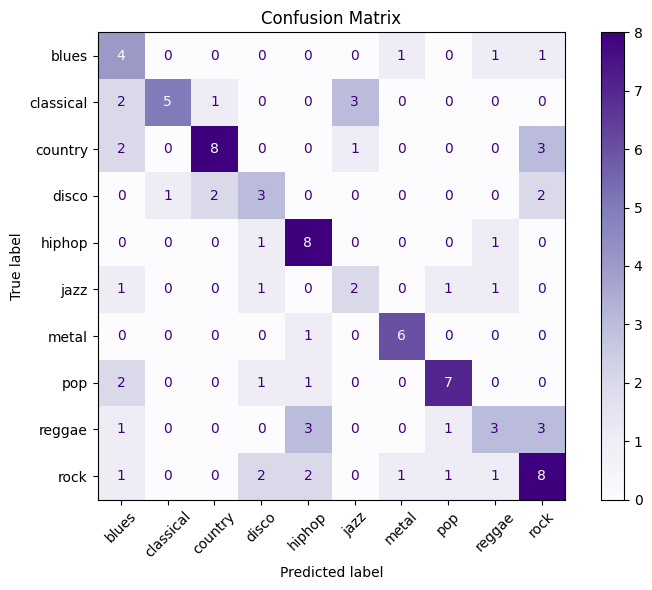

In [ ]:
print("Result of Net2 for 50 epochs:")
test_model(model_2_50)
print("\nResult of Net2 for 100 epochs:")
test_model(model_2_100)

### 3. A convolutional network obtained by modifying the one in Figure 1 by adding a batch normalisation layer.

In [12]:
import torch.nn as nn

class Net3(nn.Module):
    """
    A convolutional neural network (CNN) designed for image classification into 10 classes,
    similar in structure to Net2, but with Batch Normalization layers added after each convolution.

    Input shape: [batch_size, 3, 180, 180] where 3 is the number of color channels (RGB).

    The model consists of:
    - 4 convolutional layers (with ReLU activation and Batch Normalization)
    - 2 max-pooling layers for downsampling
    - Flattening into a 1D vector
    - 2 fully connected layers for final classification

    Output shape: [batch_size, 10] — raw class scores (logits).
    """

    def __init__(self):
        super().__init__()

        # Convolutional blocks with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.norm1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.norm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.norm3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.norm4 = nn.BatchNorm2d(256)

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=42 * 42 * 256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

        # Other layers
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()

    def forward(self, x):
        # Input shape: [batch_size, 3, 180, 180]
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        # Shape after conv1: [batch_size, 32, 178, 178]

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)
        # Shape after conv2: [batch_size, 64, 176, 176]

        x = self.pool(x)
        # Shape after first pool: [batch_size, 64, 88, 88]

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu(x)
        # Shape after conv3: [batch_size, 128, 86, 86]

        x = self.conv4(x)
        x = self.norm4(x)
        x = self.relu(x)
        # Shape after conv4: [batch_size, 256, 84, 84]

        x = self.pool(x)
        # Shape after second pool: [batch_size, 256, 42, 42]

        x = self.flatten(x)
        # Shape after flatten: [batch_size, 42*42*256]

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        # Final output: [batch_size, 10]

        return x


In [13]:
import torch.optim as optim

model_3_50 = Net3().to(device)
model_3_100 = Net3().to(device)
model_loss = nn.CrossEntropyLoss()
optimizer_50 = optim.Adam(model_3_50.parameters(), lr=0.0001)
optimizer_100 = optim.Adam(model_3_100.parameters(), lr=0.0001)

print("\nTRAINING FOR 50 EPOCHS\n")
train_model(50, model_3_50, optimizer_50)
print("\nTRAINING FOR 100 EPOCHS\n")
train_model(100, model_3_100, optimizer_100)


TRAINING FOR 50 EPOCHS

Epoch 1/50, Loss: 11.739020293409174, Accuracy: 0.15593705293276108, Val_loss: 3.1386611121041432, Val_acc: 0.1658291457286432
Epoch 2/50, Loss: 2.044804182919589, Accuracy: 0.35765379113018597, Val_loss: 3.4670253821781705, Val_acc: 0.1407035175879397
Epoch 3/50, Loss: 1.4183460094711997, Accuracy: 0.4792560801144492, Val_loss: 2.203450015613011, Val_acc: 0.37185929648241206
Epoch 4/50, Loss: 1.1233532618392597, Accuracy: 0.6022889842632332, Val_loss: 1.470032811164856, Val_acc: 0.4824120603015075
Epoch 5/50, Loss: 0.8054671693931926, Accuracy: 0.7267525035765379, Val_loss: 1.214262638773237, Val_acc: 0.5678391959798995
Epoch 6/50, Loss: 0.6688943803310394, Accuracy: 0.7782546494992847, Val_loss: 1.3671958957399641, Val_acc: 0.542713567839196
Epoch 7/50, Loss: 0.4649449735879898, Accuracy: 0.8669527896995708, Val_loss: 1.2611231122698103, Val_acc: 0.5879396984924623
Epoch 8/50, Loss: 0.2264485149220987, Accuracy: 0.9470672389127325, Val_loss: 1.166573609624590

Result of Net3 for 50 epochs:
Test_loss: 1.5585096180438995, Test_accuracy: 0.6138613861386139


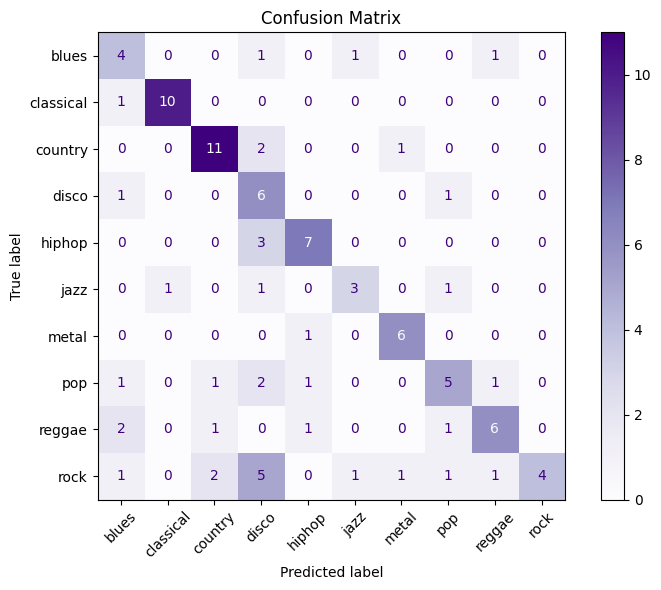


Result of Net3 for 100 epochs:
Test_loss: 1.4364509284496307, Test_accuracy: 0.6138613861386139


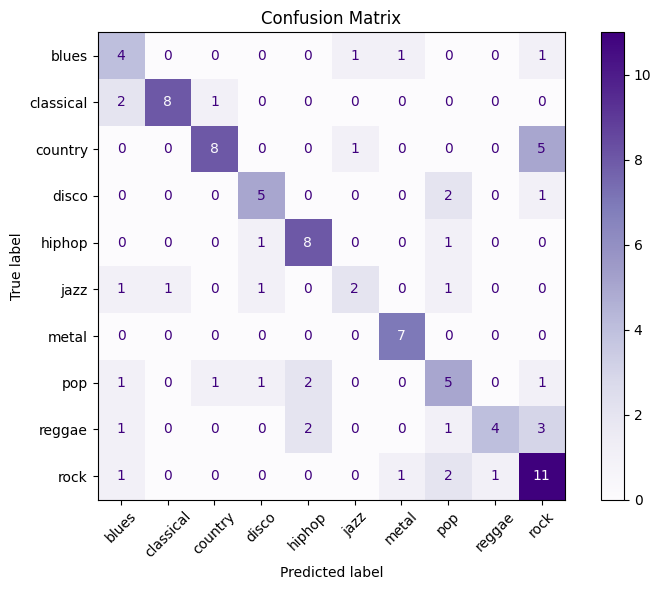

In [15]:
import matplotlib.pyplot as plt

print("Result of Net3 for 50 epochs:")
test_model(model_3_50)
print("\nResult of Net3 for 100 epochs:")
test_model(model_3_100)

### 4. The same architecture in the above 3, with the RMSProp optimiser.

In [16]:
import torch.optim as optim

# Creating two instances of Net3 model
model_4_50 = Net3().to(device)
model_4_100 = Net3().to(device)

# Defining the loss function
model_loss = nn.CrossEntropyLoss()

# Defining optimizers
# Using RMSprop optimizer instead of Adam (compared to previous training setups)
optimizer_50 = optim.RMSprop(model_4_50.parameters(), lr=0.0001)
optimizer_100 = optim.RMSprop(model_4_100.parameters(), lr=0.0001)

# Training the models
print("\nTRAINING FOR 50 EPOCHS\n")
train_model(50, model_4_50, optimizer_50)

print("\nTRAINING FOR 100 EPOCHS\n")
train_model(100, model_4_100, optimizer_100)


TRAINING FOR 50 EPOCHS

Epoch 1/50, Loss: 55.48710955273021, Accuracy: 0.07725321888412018, Val_loss: 6.780558177403042, Val_acc: 0.09547738693467336
Epoch 2/50, Loss: 3.633374257521196, Accuracy: 0.19599427753934193, Val_loss: 2.8295497553689137, Val_acc: 0.1658291457286432
Epoch 3/50, Loss: 2.603592899712649, Accuracy: 0.24606580829756797, Val_loss: 2.547771828515189, Val_acc: 0.2613065326633166
Epoch 4/50, Loss: 2.2452590465545654, Accuracy: 0.27753934191702434, Val_loss: 2.2326263870511736, Val_acc: 0.27638190954773867
Epoch 5/50, Loss: 2.265148639678955, Accuracy: 0.2947067238912732, Val_loss: 2.4821837288992747, Val_acc: 0.2964824120603015
Epoch 6/50, Loss: 1.660131579095667, Accuracy: 0.44635193133047213, Val_loss: 2.253008144242423, Val_acc: 0.2613065326633166
Epoch 7/50, Loss: 1.910591255534779, Accuracy: 0.4248927038626609, Val_loss: 1.5840565987995692, Val_acc: 0.457286432160804
Epoch 8/50, Loss: 1.8570012775334446, Accuracy: 0.4005722460658083, Val_loss: 2.258661457470485,

Result of Net3 with RMSprop optimizer for 50 epochs:
Test_loss: 2.430235832929611, Test_accuracy: 0.5445544554455446


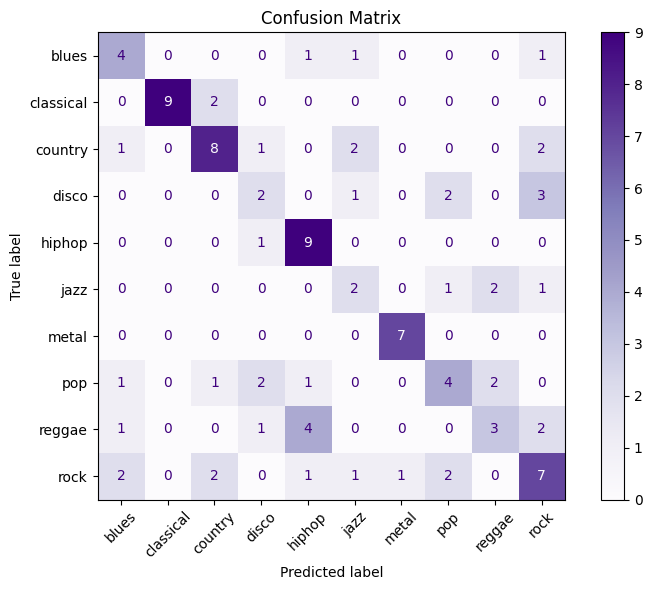


Result of Net3 with RMSprop optimizer for 100 epochs:
Test_loss: 2.909831166267395, Test_accuracy: 0.5346534653465347


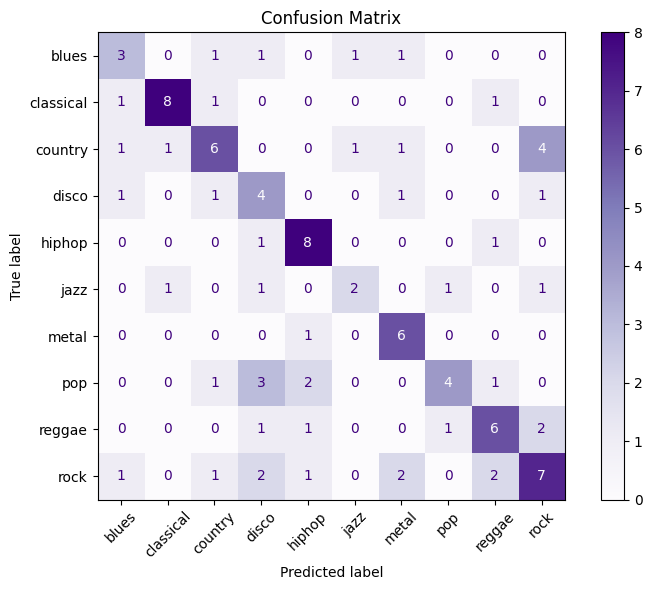

In [17]:
print("Result of Net3 with RMSprop optimizer for 50 epochs:")
test_model(model_4_50)
print("\nResult of Net3 with RMSprop optimizer for 100 epochs:")
test_model(model_4_100)